In [1]:
%matplotlib inline
import sys
sys.path.append("/home/diego/Dropbox/hold_noise/iclamp-glm/")

%load_ext autoreload
%autoreload 2

from cycler import cycler
import seaborn as sns
size = 24
sns.set(style="ticks", rc={'figure.figsize': (3.5, 3.), 'axes.labelsize': size, 'lines.linewidth': 1.4, 'lines.markersize': 10,
                           'xtick.labelsize': size, 'ytick.labelsize': size, 'errorbar.capsize': 5, 'figure.subplot.top': .98, 
                           'legend.fontsize': size, 'axes.spines.top': False, 'axes.spines.right': False,
                           'axes.prop_cycle': cycler(color=['dodgerblue', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                                                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])})

### Loading and preprocessing 9 trials of patch clamp data

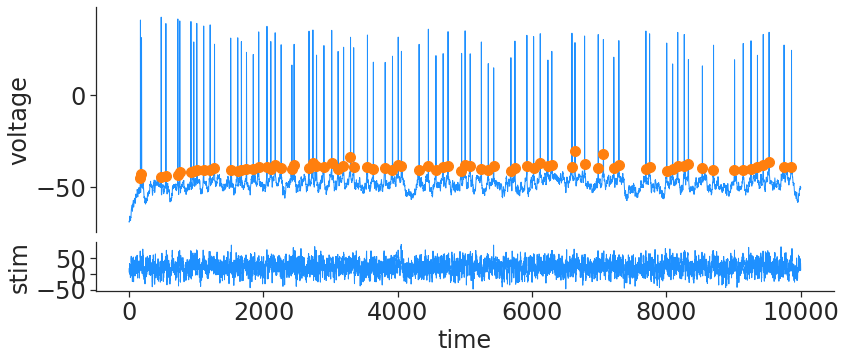

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from icglm.iclamp import IClamp

ic = IClamp.load_from_abf(path='./18o03049.abf') # load 9 repetitions of voltage response to noisy stimulation
ic = ic.subtract_Ih(th=1000.1).restrict(t0=1000.1, tf=11000.1) # subtract holding current and restrict data
ic.set_mask_spikes(thr=0, t_before_spike_peak=0.8) # set spikes
ic = ic.subsample(1) # subsample data

fig, axs = ic.plot(sweeps=[0], spikes=True)
fig.set_size_inches(12, 5)
fig.subplots_adjust(top=0.95, bottom=0.16, 
                    right=0.98, hspace=0.5)
fig.savefig('./ic_plot.png')

### Fitting encoding GLM to data

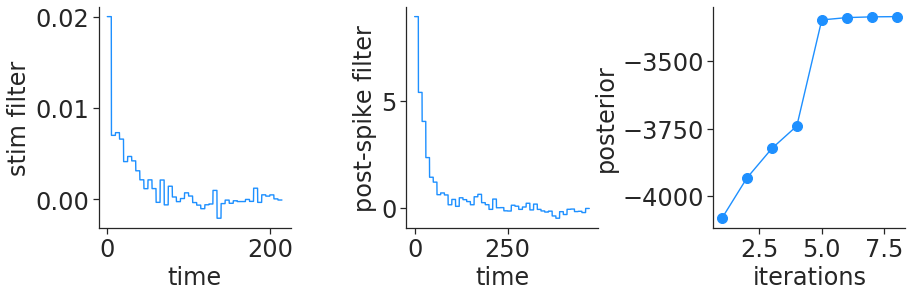

In [3]:
from icglm.models.glm import GLM
from icglm.kernels import KernelRect
from icglm.plot.fit import GLMPlotter

# define time bins and initial parameters for GLM fit
tbins_kappa = np.arange(0, 220, 5)
coefs_kappa0 = 1e-2 * np.exp(-tbins_kappa[:-1] / 50)
tbins_eta = np.arange(0, 480, 10)
coefs_eta0 = 6 * np.exp(-tbins_eta[:-1] / 50)
glm = GLM(u0=15, kappa=KernelRect(tbins_kappa, coefs_kappa0), eta=KernelRect(tbins_eta, coefs_eta0))

newton_kwargs = dict(max_iterations=30, stop_cond=5e-4, learning_rate=5e-1, initial_learning_rate=5e-2, warm_up_iterations=3)
optimizer = glm.fit(ic.t, ic.stim, ic.mask_spikes, newton_kwargs=newton_kwargs)

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 5), ncols=3)
glm_plotter = GLMPlotter(ic=ic, model=glm, optimizer=optimizer) # plotting class
glm_plotter.plot_filters(axs=(ax1, ax2))
glm_plotter.plot_posterior_iterations(ax=ax3)
fig.set_size_inches(13.5, 4)
fig.subplots_adjust(top=0.97, bottom=0.2, wspace=0.6,
                    left=0.15, right=0.98)
fig.savefig('./filters.png')

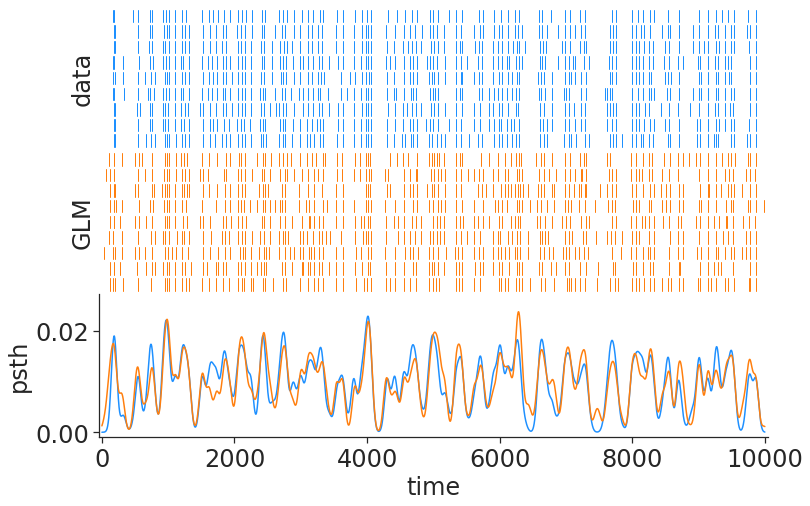

In [4]:
from icglm.kernels import KernelFun
from icglm.spiketrain import SpikeTrain

psth_kernel = KernelFun.gaussian_delta(delta=40)
v, r, mask_spikes = glm.sample(ic.t, ic.stim) # simulating 9 repetitions of fit GLM
glm_plotter.mask_spikes_model = mask_spikes

# compute psths
glm_plotter.psth_model = SpikeTrain(ic.t, mask_spikes).get_psth(psth_kernel) 
glm_plotter.psth_exp = SpikeTrain(ic.t, ic.mask_spikes).get_psth(psth_kernel)

fig, axs = glm_plotter.plot_raster()
fig.savefig('./raster_plot.png')

### Decoding stimulus from spike data and GLM

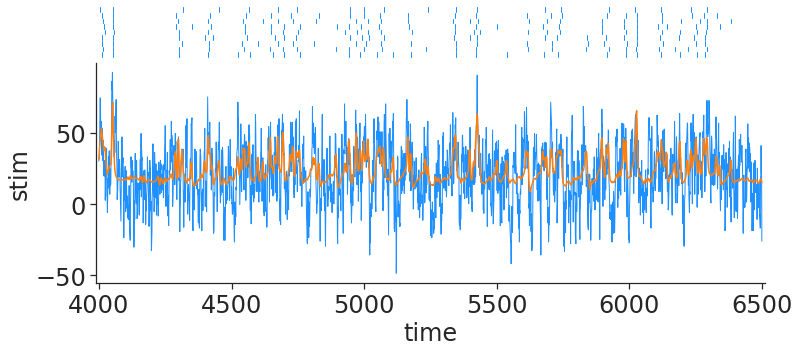

In [5]:
from icglm.processes import OUProcess
from icglm.plot.decoding import DecodingPlotter

mu, sd = np.mean(ic.stim), np.mean(np.std(ic.stim, 0))
ou = OUProcess(mu=mu, sd=sd, tau=3) # define prior for decoding
stim_true = ic.stim[:, 0]
stim0 = np.zeros(len(ic.t)) + mu # define initial stimulus

newton_kwargs = dict(learning_rate=1e-1, stop_cond=2e-6, max_iterations=20)
stim_dec, optimizer = glm.decode(ic.t, ic.mask_spikes, stim0=stim0, prior=ou, newton_kwargs=newton_kwargs)

dec_plotter = DecodingPlotter(t=ic.t, model=[glm], optimizer=optimizer, mask_spikes=[ic.mask_spikes], stim_dec=stim_dec, stim_true=stim_true) # plotting class
fig, axs = dec_plotter.plot_decoded_stimulus(t0=4000, tf=6500)
fig.savefig('./decoding_plot.png')